# Lending Club dataset

**LendingClub.com** - це P2P сервіс із кредитування. Сервіс зацікавлений у тому, щоб заздалегідь виявляти займи із більшим ризиком, тож вони опублікували частину своїх даних. Датасет містить такі змінні:

1. `credit.policy` – показує, чи відповідає позичальник критеріям кредитування LendingClub. Якщо 1, то так, якщо 0, то ні.
1. `purpose` – причина взяття кредиту. Це може бути:
    - **credit_card** – погашення боргу за кредитною карткою,
    - **debt_consolidation** – об'єднання кількох боргів в один кредит,
    - **educational** – навчання,
    - **major_purchase** – велика покупка (наприклад, авто),
    - **small_business** – для бізнесу,
    - **all_other** – інші цілі.
1. `int.rate` – річна відсоткова ставка по кредиту (якщо 11%, то тут буде записано 0.11). Чим вищий ризик неповернення грошей, тим вища ставка.
1. `installment` – щомісячний платіж за кредитом.
1. `log.annual.inc` – логарифм річного доходу позичальника.
1. `dti` – співвідношення боргу до доходу (загальна сума боргів поділена на річний дохід). Чим більше значення, тим більша фінансова навантаженість.
1. `fico` – кредитний рейтинг (FICO score). Він варіюється від 300 до 850: чим вищий бал, тим краще кредитна історія.
1. `days.with.cr.line` – скільки днів у позичальника є кредитна історія (тобто, як давно він почав користуватися кредитами).
1. `revol.bal` – баланс заборгованості на кредитних картах (сума, яку людина не погасила в кінці місяця).
1. `revol.util` – використана частка кредитного ліміту (наприклад, якщо у вас ліміт $10,000 і ви використали 3,000, то значення буде 30%).
1. `inq.last.6mths` – скільки разів за останні 6 місяців банки або кредитні організації перевіряли кредитну історію позичальника (чим більше перевірок, тим більше ризик, що людина шукає кредит через фінансові труднощі).
1. `delinq.2yrs` – скільки разів за останні 2 роки людина затримувала платіж більше ніж на 30 днів.
1. `pub.rec` – скільки разів у людини були негативні публічні записи (наприклад, банкрутство, податкові борги або судові рішення про стягнення грошей).
1. `not.fully.paid` – цільова змінна. Вказує, чи людина не виплатила кредит повністю:
    - **0** – кредит повністю погашено,
    - **1** – є прострочена заборгованість.

В цій задачі ми не зможемо досягнути високої точності через складну природу цільової змінної. Проте ми можемо потренуватися у пошуку балансу між помилками 1 та 2 типу.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm

# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [2]:
data = pd.read_csv('datasets/loan_data.csv')
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


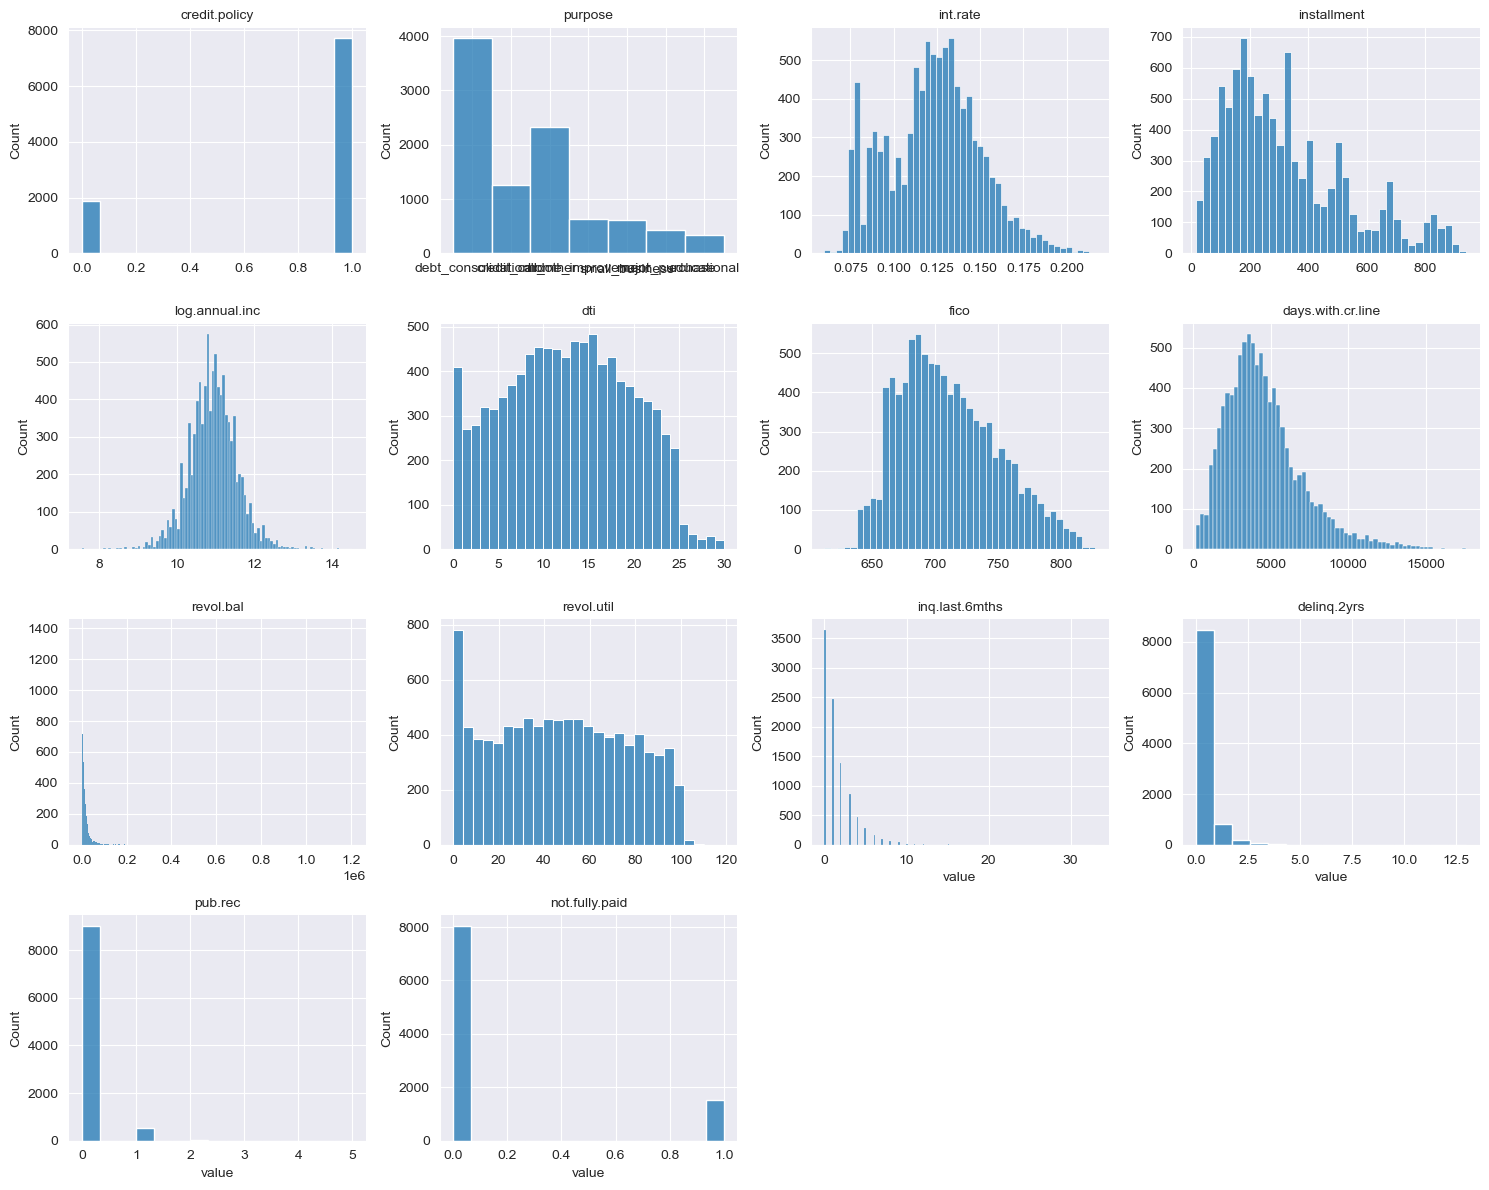

In [3]:
sns.set_style('darkgrid')
melted = data.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')
g.set_titles(col_template='{col_name}')
g.tight_layout()

Змінна `revol.bal` має виражений логнормальний розподіл, тож краще залогарифмувати її.

In [4]:
data['revol.bal'] = np.log1p(data['revol.bal'])

Бачимо, що класи в цільовій змінній сильно незбалансовані.

In [5]:
print(f"% невиплачених до кінця кредитів: {data['not.fully.paid'].mean():.2%}")

% невиплачених до кінця кредитів: 16.01%


<Axes: >

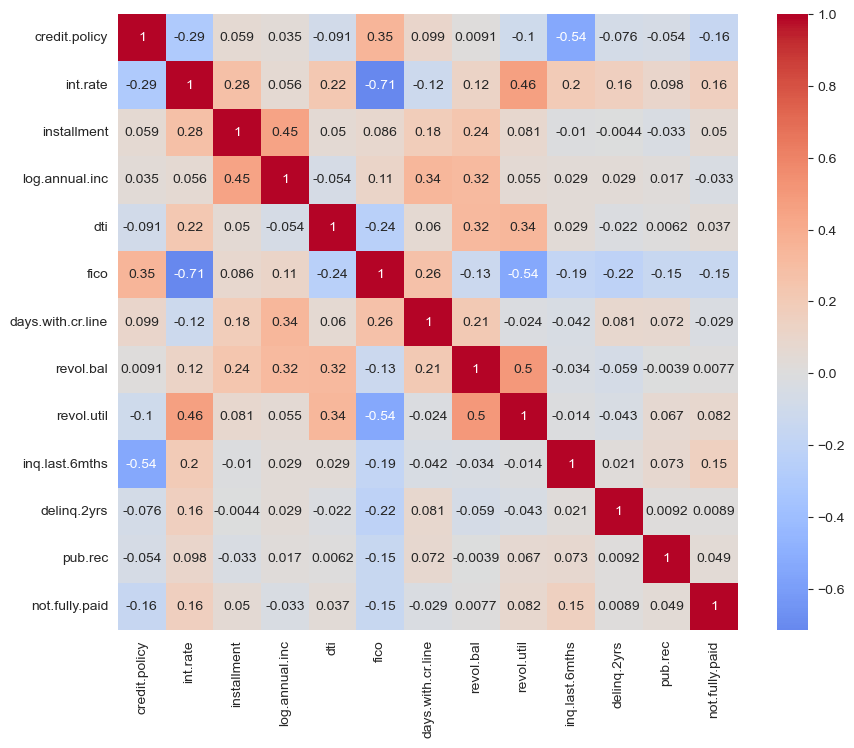

In [6]:
plt.subplots(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), cmap='coolwarm', annot=True, center=0)

Перевіримо пару змінних з найвищо кореляцією: `fico` та `int.rate`. Поки не будемо видаляти жодну із цих змінних, натомість скористаємося звітом зі `statsmodels`.

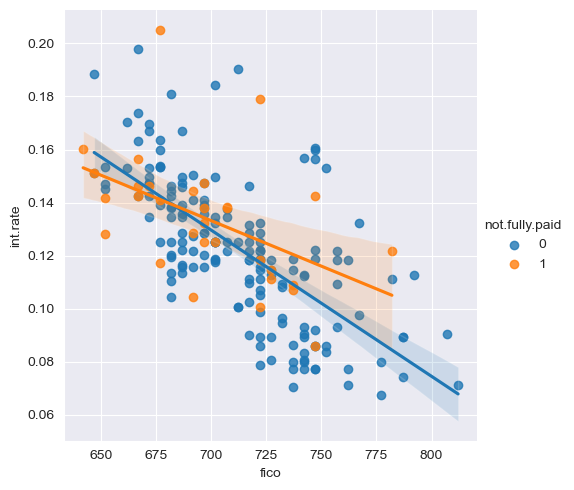

In [7]:
sns.lmplot(data.sample(200), x='fico', y='int.rate', hue='not.fully.paid')

<Axes: xlabel='fico', ylabel='Count'>

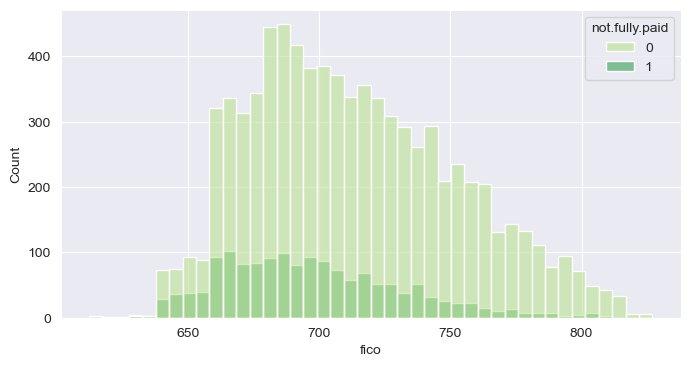

In [8]:
plt.subplots(figsize=(8, 4))
sns.histplot(data, x='fico', hue='not.fully.paid', alpha=0.6, palette='YlGn')

C:\Users\Rogue S\AppData\Local\Temp\ipykernel_14504\323541767.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45)


[Text(0, 0, 'debt_consolidation'),
 Text(1, 0, 'credit_card'),
 Text(2, 0, 'all_other'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'educational')]

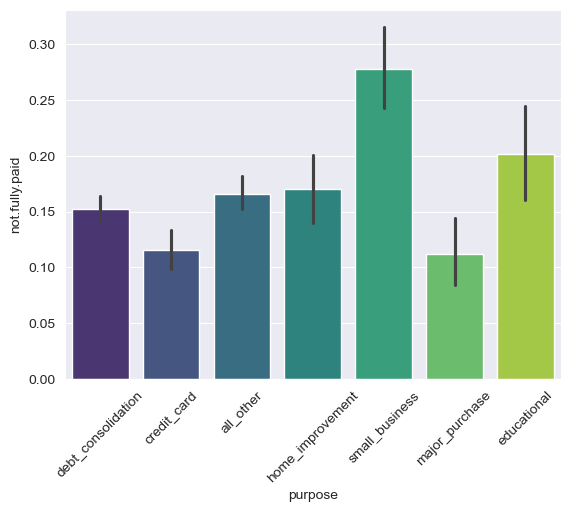

In [9]:
fig = sns.barplot(data, x='purpose', y='not.fully.paid', palette='viridis', hue='purpose')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)

## Поділ вибірки на числову та категоріальну частини, кодування та масштабування змінних
Кодування варто виконувати після подіну даних на тренувальну і тестову вибірки. Тут ми можемо дозволити собі спростити кодування з огляду на те, що в номінальній змінній маємо лише невелику кількість категорій, всі з яких будуть точно представлені у тренувальних даних.

In [10]:
purpose_column = pd.get_dummies(data['purpose'], drop_first=True)
y = data['not.fully.paid']
X = data.drop(columns=['purpose', 'not.fully.paid'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
scaler = pp.PowerTransformer().set_output(transform='pandas')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[purpose_column.columns] = purpose_column.loc[X_train.index].astype(int)
X_test[purpose_column.columns] = purpose_column.loc[X_test.index].astype(int)

## Навчання логістичної моделі

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
prediction = model.predict(X_test)
print(prediction)

[0 0 0 ... 0 0 0]


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2408
           1       0.50      0.02      0.03       466

    accuracy                           0.84      2874
   macro avg       0.67      0.51      0.47      2874
weighted avg       0.78      0.84      0.77      2874



<Axes: >

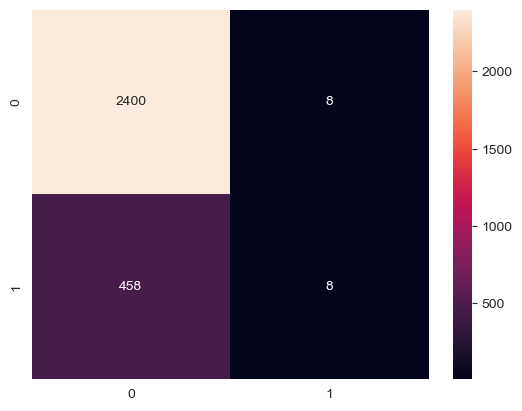

In [14]:
print(classification_report(y_test, prediction))
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='.0f')

Враховуючи розподіл класів (лише 16% займів не було сплачено), ми вгадаємо у `100% - 16% = 84%` випадків, якщо завжди будемо передбачати `0`. Цей випадок є оптимальним для моделі з точки зору `accuracy`, проте решта показників мають незадовільні значення. Це робить метрику `accuracy` ненадійною при незбалансованих класах. В таких випадках, більше підходять метрики `balanced accuracy` (`macro avg recall`), та `f1 score` для менш поширеного класу.

В даному випадку, для врахування дизбалансу класів можемо використати три способи.

### Спосіб 1. `class_weight`
Багато (але не всі) алгоритми класифікації в `sklearn` мають параметр `class_weight`. Ці ваги алгоритм використовує в процесі навчання, вони ніяк не змінюють вхідні дані. Кожен алгоритм враховує ваги по-своєму. В даному випадку, можемо задати автоматичний вибір ваг через значення `'balanced'`, або задати значення самостійно у вигляді словника, наприклад `{0: 1, 1: 5}`. Тут 0 і 1 - назви класів, 1 і 5 - ваги. Ваги можуть бути будь-якими числами, цілими чи дробовими, у довільному масштабі. Під час навчання моделі буде враховуватися лише співвідношення між ними.

              precision    recall  f1-score   support

           0       0.90      0.66      0.76      2408
           1       0.26      0.61      0.36       466

    accuracy                           0.65      2874
   macro avg       0.58      0.63      0.56      2874
weighted avg       0.79      0.65      0.69      2874



<Axes: >

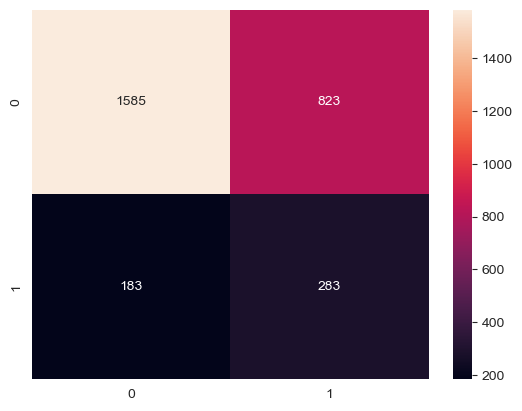

In [15]:
model = LogisticRegression(class_weight='balanced')
# model = LogisticRegression(class_weight={0: 1, 1: 5})
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='.0f')

### Спосіб 2. Встановлення порогу
Деякі алгоритми (наприклад, логістична регресія і наївний Баєс) передбачають не лише клас, але і ймовірність входження до нього. Для таких методів стандартною є порогова ймовірніть 0.5 (для бінарної класифікації), але можна встановити власний поріг.

Поріг, так само як ваги класів, потрібно вибирати із бажаного співвідношення між помилками 1 та 2 типів. На практиці, це співвідношення має залежати від предмемети прогнозування. 

In [16]:
prediction_probabilities = model.predict_proba(X_test)
prediction_probabilities

array([[0.22735902, 0.77264098],
       [0.54155282, 0.45844718],
       [0.63188412, 0.36811588],
       ...,
       [0.83590813, 0.16409187],
       [0.47057541, 0.52942459],
       [0.6416421 , 0.3583579 ]])

              precision    recall  f1-score   support

           0       0.91      0.53      0.67      2408
           1       0.23      0.73      0.35       466

    accuracy                           0.56      2874
   macro avg       0.57      0.63      0.51      2874
weighted avg       0.80      0.56      0.62      2874



<Axes: >

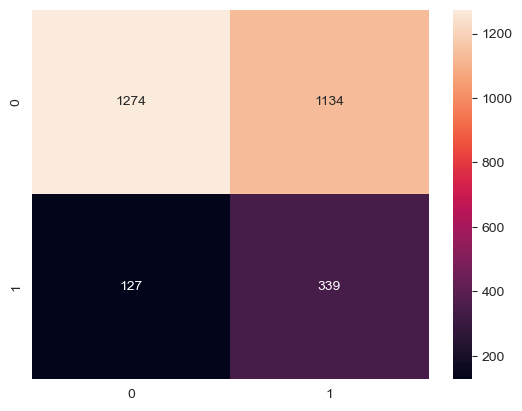

In [17]:
prediction = (prediction_probabilities[:, 1]>=0.45).astype(int)
print(classification_report(y_test, prediction))
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='.0f')

### Спосіб 3. Балансування даних
Останній спосіб полягає в зміні вхідних даних. Ідея полягає у тому, щоб використати менше рядків, що належать до більш поширеного класу (*under-sampling*), або згенерувати нові рядки для більш рідкісного класу, схожі на вже наявні (*over-sampling*). Різні варіації цих алгоритмів є у бібілотеці `imblearn`. Прочитати більше про ці методи можна в [документації бібліотеки imblearn](https://imbalanced-learn.org/stable/over_sampling.html).

**Зверніть увагу**, що ми застосовуємо ресемплінг лише до **тренувальних даних**, тестовий набір залишаємо без змін.

In [27]:
import warnings
warnings.filterwarnings("ignore")
smote = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.91      0.46      0.61      2408
           1       0.22      0.78      0.34       466

    accuracy                           0.51      2874
   macro avg       0.57      0.62      0.48      2874
weighted avg       0.80      0.51      0.57      2874



<Axes: >

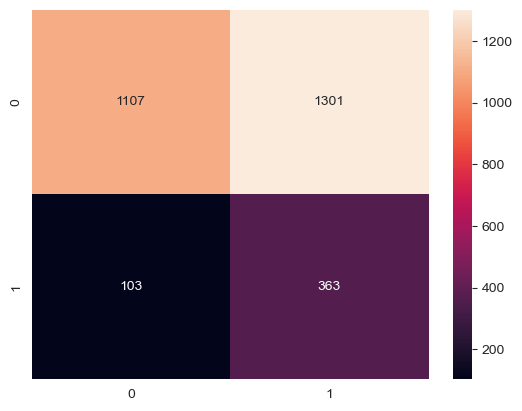

In [19]:
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='.0f')

## Використання логістичної регресії з бібліотеки `statsmodels`

In [20]:
import statsmodels.api as sm
logmodel = sm.Logit(y_train_resampled, X_train_resampled).fit()
print(logmodel.summary())

Optimization terminated successfully.
         Current function value: 0.563130
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not.fully.paid   No. Observations:                 8175
Model:                          Logit   Df Residuals:                     8157
Method:                           MLE   Df Model:                           17
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                  0.1285
Time:                        23:21:04   Log-Likelihood:                -4603.6
converged:                       True   LL-Null:                       -5282.1
Covariance Type:            nonrobust   LLR p-value:                2.595e-278
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
credit.policy         -0.2793      0.030     -9.389      0.000      -0.338      -0.221
int.r

## Навчання дерева рішень

Дерево рішень 1. Без балансування класів

In [21]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
prediction = tree_model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      2408
           1       0.18      0.19      0.19       466

    accuracy                           0.73      2874
   macro avg       0.51      0.51      0.51      2874
weighted avg       0.74      0.73      0.73      2874



Дерево рішень 2. Балансуваання через `class_weight`.

In [22]:
tree_model = DecisionTreeClassifier(class_weight={0:1, 1: 6})
tree_model.fit(X_train, y_train)
prediction = tree_model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2408
           1       0.22      0.22      0.22       466

    accuracy                           0.75      2874
   macro avg       0.53      0.53      0.53      2874
weighted avg       0.75      0.75      0.75      2874



Дерево рішень 3. Балансування через `SMOTE`.

In [23]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_resampled, y_train_resampled)
prediction = tree_model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74      2408
           1       0.21      0.48      0.29       466

    accuracy                           0.62      2874
   macro avg       0.54      0.56      0.52      2874
weighted avg       0.76      0.62      0.67      2874



Бачимо, що дерева рішень малочутливі до налаштування ваги класів через `class_weight`, проте результат можна покращити балансуванням даних.

## Важливість класів згідно моделей
Подібно до лінійної регресії, логістична регресія розраховує коефіцієнти для кожної вхідної змінної. Ці коефіцієнти, при використанні однакової шкали для усіх змінних, умовно можна вважати їхньою важливістю для цієї моделі.

<Axes: >

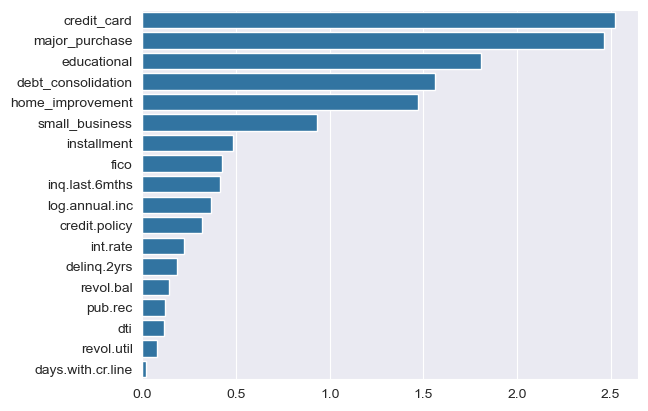

In [24]:
features = pd.Series(np.abs(model.coef_[0]), index=X_train.columns).sort_values(ascending=False)
sns.barplot(features, orient='h')

Дерева рішень та всі алгоритми, що їх використовують, дають більш надійні та інтуїтивні оцінки важливості ознак.

<Axes: >

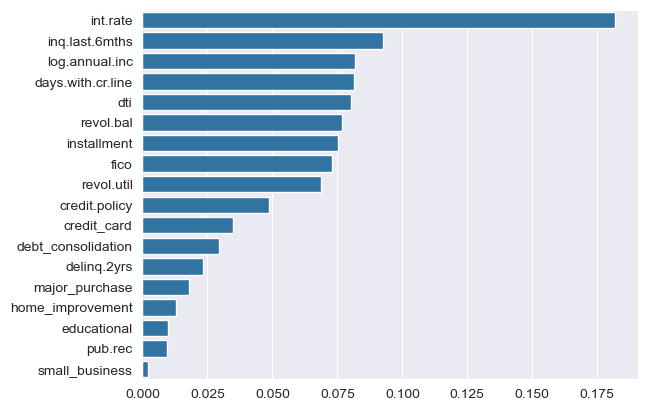

In [25]:
features = pd.Series(np.abs(tree_model.feature_importances_), index=X_train.columns).sort_values(ascending=False)
sns.barplot(features, orient='h')